# Example of usage Spark OCR for Signature Detection

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
'''
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
imagePath = "./data/signature/LIL18369-Lease_Z-1.jpg"

'''


In [1]:
secret = ""

spark_ocr_jar_path = "../../target/scala-2.11"
imagePath = "./data/signature/LIL18369-Lease_Z-1.jpg"

In [ ]:
#%env JSL_OCR_LICENSE =

In [ ]:
#%env AWS_ACCESS_KEY_ID=


In [ ]:
#%env AWS_SECRET_ACCESS_KEY=

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import os
import sys

'''
if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

'''

In [2]:
#%pip install ../../python/dist/spark-ocr-3.3.0.spark24.tar.gz

Processing /Users/chico/IdeaProjects/spark-ocr/python/dist/spark-ocr-3.3.0.spark23.tar.gz
  Using cached pyspark-2.3.4-py2.py3-none-any.whl
  Using cached py4j-0.10.7-py2.py3-none-any.whl (197 kB)
  Created wheel for spark-ocr: filename=spark_ocr-3.3.0.spark23-py3-none-any.whl size=16461425 sha256=8fde7f847ce5f4d298148f9355228befb38a74199bb07bcb91f0e464dc8aae5c
  Stored in directory: /Users/chico/Library/Caches/pip/wheels/77/78/96/d22be138eadec2da52a96b18cf24ebe9f0b2fdcb33362248eb
Failed to build spark-ocr
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9
    Uninstalling py4j-0.10.9:
      Successfully uninstalled py4j-0.10.9
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.0.2
    Uninstalling pyspark-3.0.2:
      Successfully uninstalled pyspark-3.0.2
  Attempting uninstall: spark-ocr
    Found existing installation: spark-ocr 3.3.0.spark30
    Uninstalling spark-ocr-3.3.0.spark30:
      Successfully uninstalled spark-ocr-3.3.0.spark

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [3]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.0")

spark

Spark version: 2.4.7
Spark NLP version: 2.5.5
Spark OCR version: 3.3.0



In [4]:
spark.sparkContext.setLogLevel("DEBUG")


## Read images and display it


    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/signature/LIL18369-Lease_Z-1.jpg
    Resolution: 0 dpi
    Width: 612 px
    Height: 792 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


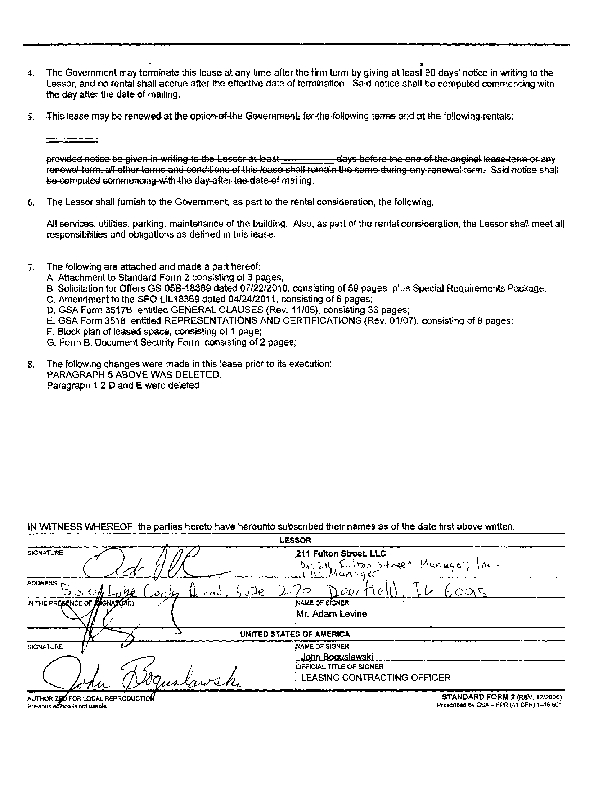

In [5]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [6]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_signature_detector_gsa0611", "en", "public/ocr/models")
signature_detector = ImageSignatureDetector()
signature_detector.pretrained(*pretrained_model)
signature_detector.setInputCol("image")
signature_detector.setOutputCol("signature_regions")

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("signature_regions")
draw_regions.setOutputCol("image_with_regions")

pipeline = PipelineModel(stages=[
    binary_to_image,
    signature_detector,
    #draw_regions
])

image_signature_detector_gsa0611 download started this may take some time.
Approximate size to download 247.1 MB


## Run pipeline and show results

In [7]:
result =  pipeline.transform(image_df)
#display_images(result, "image_with_regions")

In [8]:
result = result.withColumn("coordinate", f.explode(f.col("signature_regions.coordinates"))).select("coordinate")


In [9]:
result = result.where(f.col("coordinate").isNotNull())


In [10]:
assert( result.count() > 0 )

AssertionError: 

In [12]:
result.count()

0